<a href="https://colab.research.google.com/github/SatyamPawale/COMPUTER-VISION/blob/main/Copy_of_DL_Sheet03_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - Winter Term 2025/2026

<hr style="border:2px solid gray">

### Exercise Sheet 03

<br>

## 4.1 Implement different optimizer for SimpleCNN
In this exercise we will make use of the CNN model we have seen in the lecture. We will handcraft different optimizers and see how they work on MNIST dataset. We continue with our approach and try to 'dive into' PyTorch and make our own implementations.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
# Typical check - if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cuda


In [3]:
# This will automatically download the data and store it in the folder "data".
train_data = torchvision.datasets.MNIST(
    root = 'data',
    train = True,
    transform = torchvision.transforms.ToTensor(),
    download = True,
)
test_data = torchvision.datasets.MNIST(
    root = 'data',
    train = False,
    transform = torchvision.transforms.ToTensor()
)

# Let's check what we have.
print(train_data)
print()
print(test_data)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 553kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


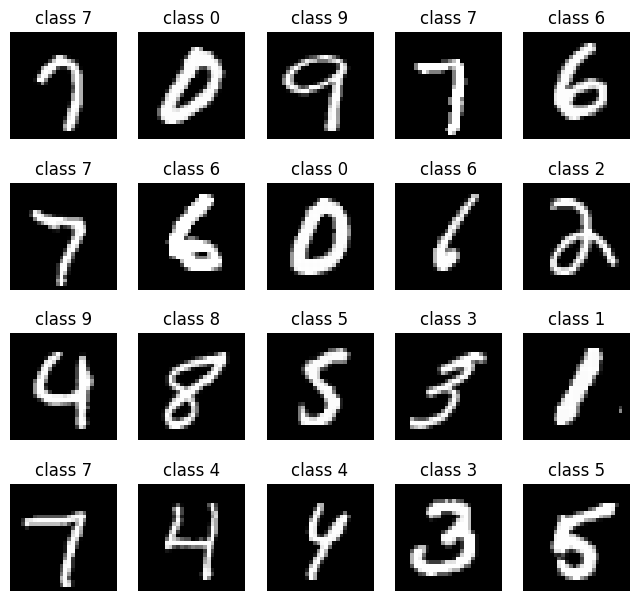

In [4]:
# Now let's visualize some examples.
fig = plt.figure(figsize=(8, 7.5))
fig.tight_layout()
rows, cols = 4, 5

# For reproducibility.
torch.manual_seed(1)

for i in range(rows * cols):
    # Grab random example from training set.
    sample_idx = torch.randint(len(train_data), (1, )).item()
    x, y = train_data[sample_idx]

    # Plot image with with target class.
    fig.add_subplot(rows, cols, i + 1)
    plt.title("class {}".format(y))
    plt.axis("off")
    plt.imshow(x.squeeze(), cmap="gray")

plt.show()

In [5]:
# Now we transfer the data into data loaders -> data loaders
# are very helpful. They will organize data in batches for us.
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=128,
    shuffle=True, #SGD
    pin_memory=True, # can accelerate GPU training.
    num_workers=1
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=100,
    shuffle=True,
    num_workers=1
)

print(train_loader)
print(test_loader)

In [6]:
# Now we setup up our first CNN model.
class SimpleCNN(torch.nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()

        # First convolution layer (Conv -> ReLU -> MaxPooling)
        # The sequential instruction automatically
        # chains incorporated operations.
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )

        # Second convolution layer.
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )

        # Now we add a fully connected layer that maps
        # all channels from the remaining resolution (7x7)
        # onto 10 units (each representing one class).
        self.out = torch.nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        # First conv
        out = self.conv1(x)
        # Second conv
        out = self.conv2(out)

        # Now we flatten the output of conv2 match the linear
        # mapping of the fully connected layer 32 * 7 * 7 -> 10.
        out = out.view(out.size(0), -1)
        out = self.out(out)
        return out

In [7]:
# We can create an instance of our model and put it on the target device.
model = SimpleCNN().to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print("num_params:", num_params)

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
num_params: 28938


In [8]:
# We define the loss function we need for training.
# Softmax is already implemented in CrossEntropyLoss
criterion = torch.nn.CrossEntropyLoss()
print(criterion)

CrossEntropyLoss()


Previous cells were used already in the lecture. Now you will implement three optimizers and use them to train the SimpleCNN on MNIST dataset. You can test your implementation by training the same model with PyTorch optimizers. They should behave similarly (small differences may occur).

Normally, we would set up the optimizer using PyTorch with the following line:

```optimizer = torch.optim.Adam(model.parameters(), lr=0.005)```

But here, we want you to learn how things work under the hood. Hence, you will implement some optimizers and test them on MNIST.

In [9]:
# Basic Stochastic Gradient Descent
# TODO: apply momentum to the weight update
class SGD():

    def __init__(self, params, momentum, lr):
        # Initialize the input parameters
        self.params   = list(params) # model.parameters() is a generator
        self.lr       = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(p) for p in self.params]

    def zero_grad(self):
      for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


    # If we don't use this decorator (or "with torch.no_grad():")
    # the weight updates would become part of the computational graph
    # (what we don't want here).
    @torch.no_grad()
    def step(self):
       for i, p in enumerate(self.params):
            if p.grad is None:
                continue
            self.v[i].mul_(self.momentum).add_(p.grad)
            p.sub_(self.lr * self.v[i])

    # Generates a string representation for an instance.
    def __repr__(self):
        return '\n'.join([str(__class__.__name__), 'mommentum:' + str(self.momentum), 'lr: ' + str(self.lr)])

In [10]:
class RMSprop():

    def __init__(self, params, lr, gamma, eps):
        self.params = list(params)
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.v = [torch.zeros_like(p) for p in self.params]

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue
            self.v[i].mul_(self.gamma).addcmul_(p.grad, p.grad, value=1 - self.gamma)
            p.sub_(self.lr * p.grad / (self.v[i].sqrt() + self.eps))

    def __repr__(self):
        return '\n'.join([str(__class__.__name__) + ' (',
                          '   lr: ' + str(self.lr),
                          '   gamma: ' + str(self.gamma),
                          '   eps: ' + str(self.eps), ')'])

In [11]:
class Adam:

    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.ctr = 0
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        self.ctr += 1
        beta1, beta2 = self.betas

        for i, p in enumerate(self.params):
            if p.grad is None:
                continue

            # Update biased first moment estimate
            self.m[i].mul_(beta1).add_(p.grad, alpha=1 - beta1)

            # Update biased second raw moment estimate
            self.v[i].mul_(beta2).addcmul_(p.grad, p.grad, value=1 - beta2)

            # Bias correction
            m_hat = self.m[i] / (1 - beta1 ** self.ctr)
            v_hat = self.v[i] / (1 - beta2 ** self.ctr)

            # Parameter update
            p.sub_(self.lr * m_hat / (v_hat.sqrt() + self.eps))

    def __repr__(self):
        return '\n'.join([
            f"{self.__class__.__name__}(",
            f"  lr={self.lr},",
            f"  betas={self.betas},",
            f"  eps={self.eps}",
            ")"
        ])


In [12]:
model = SimpleCNN().to(device)

### Note: In order to compare the optimizers, you need to
### initialize the model again. To do that, basically
### run this cell again. The model is initialized
### in the first line of this cell.

# Compare SGD with your and Torch's implementation
optimizer = SGD(model.parameters(), momentum=0.9, lr=0.1)
# optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)

# Compare RMSprop with your and Torch's implementation
# optimizer = RMSprop(model.parameters(), lr=0.001, gamma=0.999, eps=1e-08)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.999, eps=1e-08)

# Compare Adam with your and Torch's implementation
# optimizer = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

print(optimizer)

# Now let's do the training loop.
num_epochs = 2

# Set model to train mode -> relevant later with dropout etc.
model.train()

# Get the number of iterations per epoch.
total_steps = len(train_loader)

# Epoch loop.
for epoch in range(num_epochs):

    # Iterate over all mini batches.
    for i, (x, y) in enumerate(train_loader):

        # Put data to device.
        x = x.to(device)
        y = y.to(device)

        # Do forward pass.
        y_pred = model(x)

        # Calc loss. Note the target is an integer {0, ..., 9}.
        # The loss function will automatically process this loss
        # adequately (i.e. as we have used a onehot vector).
        loss = criterion(y_pred, y)

        # Now we perform backprop. The gradient is of the entire
        # batch is automatically averaged by default.
        loss.backward()

        # Perform optimizer step.
        optimizer.step()

        # Clear gradients (.grad tensors of all parameter tensors)
        optimizer.zero_grad()

        # Do some logging.
        if (i + 1) % 20 == 0:
            print(
                "Epoch [{}/{}], iteration [{}/{}], loss: {:.4f}".format(
                   epoch + 1, num_epochs, i + 1, total_steps, loss.item()
                )
            )
print("Done.")

SGD
mommentum:0.9
lr: 0.1
Epoch [1/2], iteration [20/469], loss: 0.6514
Epoch [1/2], iteration [40/469], loss: 0.1014
Epoch [1/2], iteration [60/469], loss: 0.1949
Epoch [1/2], iteration [80/469], loss: 0.0936
Epoch [1/2], iteration [100/469], loss: 0.0505
Epoch [1/2], iteration [120/469], loss: 0.0366
Epoch [1/2], iteration [140/469], loss: 0.0742
Epoch [1/2], iteration [160/469], loss: 0.0686
Epoch [1/2], iteration [180/469], loss: 0.1400
Epoch [1/2], iteration [200/469], loss: 0.0433
Epoch [1/2], iteration [220/469], loss: 0.0990
Epoch [1/2], iteration [240/469], loss: 0.0983
Epoch [1/2], iteration [260/469], loss: 0.1319
Epoch [1/2], iteration [280/469], loss: 0.1769
Epoch [1/2], iteration [300/469], loss: 0.1774
Epoch [1/2], iteration [320/469], loss: 0.0180
Epoch [1/2], iteration [340/469], loss: 0.0846
Epoch [1/2], iteration [360/469], loss: 0.0421
Epoch [1/2], iteration [380/469], loss: 0.0292
Epoch [1/2], iteration [400/469], loss: 0.2052
Epoch [1/2], iteration [420/469], loss

In [13]:
# Now lets test our model for generalization on unseen examples.
# Activate test mode.
model.eval()

# Used later ...
temp_x = None
temp_y = None
temp_y_pred = None

# We don't need gradients for testing (faster, saves resources)
with torch.no_grad():
    correct = 0
    total = 0

    for x, y in test_loader:

        # Put data to device.
        x = x.to(device)
        y = y.to(device)

        # Do forward pass.
        y_pred = model(x)

        # Transform into integer.
        y_pred = torch.max(y_pred, 1)[1].data.squeeze()

        correct += (y_pred == y).sum().item()
        total += y.size(0)

        # remember last batch for later.
        temp_x = x
        temp_y = y
        temp_y_pred = y_pred

    acc = float(correct) / float(total)

    print("Final average test accuracy: {:.2f}%".format(acc * 100.0))

Final average test accuracy: 98.90%


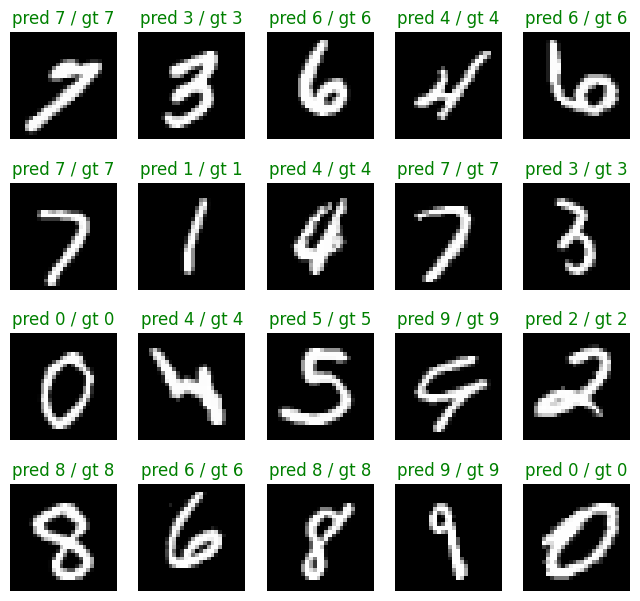

In [14]:
# Let's check some examples from the last test batch.
fig = plt.figure(figsize=(8, 7.5))
fig.tight_layout()
rows, cols = 4, 5

for i in range(rows * cols):
    # Grab examples from the test batch set.
    x = temp_x[i]
    y = temp_y[i]
    y_pred = temp_y_pred[i]

    # Plot image with with target class.
    fig.add_subplot(rows, cols, i + 1)

    color = "red"
    if y_pred == y:
        color = "green"

    plt.title("pred {} / gt {}".format(y_pred, y), color=color)
    plt.axis("off")
    plt.imshow(x.cpu().squeeze().numpy(), cmap="gray")

plt.show()

